In [1]:
%matplotlib widget
import os
import re
import pandas
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
from lmfit import Model
import pickle

from matplotlib.widgets import SpanSelector,Button
from ipywidgets import interact, interact_manual, FloatSlider, Dropdown, SelectionRangeSlider , Output
from IPython.display import display 

# 1) Manipulating the excel:

* All comments will be typed in blue next to a hastag.
* Please complete the cells where there are empty spaces and comments presented

In [2]:

data = pandas.read_excel(r"C:\Users\Francel\Masters project\CoaD Data\4_10_2023\ATP_30mM\Run 1\ATP_30 mM_Run 1_04_10_2023.xlsx")
data.head()


,Time [s],A01,B01,C01,D01,E01,F01
0,0,1.134,1.123,1.128,1.161,1.093,1.134
1,6,1.137,1.119,1.115,1.154,1.091,1.132
2,12,1.132,1.124,1.113,1.158,1.089,1.122
3,18,1.124,1.112,1.106,1.156,1.086,1.119
4,24,1.116,1.103,1.101,1.152,1.087,1.117


In [3]:
data['Time_min'] = (data['Time [s]'] / 60)
data = data.drop(['Time [s]'], axis=1)
data = data[['Time_min','A01','B01','C01','D01','E01','F01']]

# 2) Selecting initial rates: 

In [4]:
data.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data.columns]
data.head()

,Time_min,Sample_A01,Sample_B01,Sample_C01,Sample_D01,Sample_E01,Sample_F01
0,0.0,1.134,1.123,1.128,1.161,1.093,1.134
1,0.1,1.137,1.119,1.115,1.154,1.091,1.132
2,0.2,1.132,1.124,1.113,1.158,1.089,1.122
3,0.3,1.124,1.112,1.106,1.156,1.086,1.119
4,0.4,1.116,1.103,1.101,1.152,1.087,1.117


In [5]:
samples = [s for s in data.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*2]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data.index,
    index=(0,40),
    description='Time_min')

In [6]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        self.out = Output()
        display(self.out)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, interactive=True,
                    props=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        xmin, xmax = self.span.extents
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
   

Output()

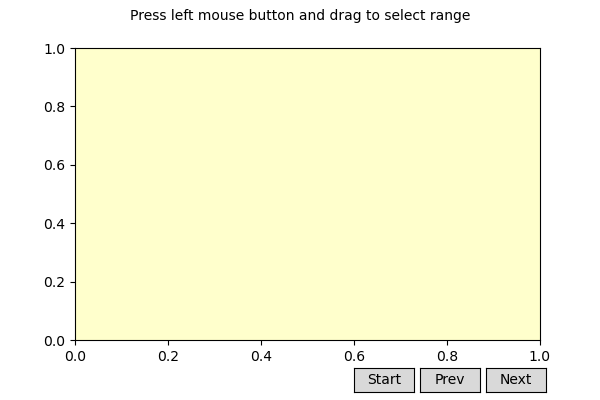

In [7]:
# Here you need to select the initial rates!
# Make use of the slider to select the initial rates by clicking on the "start" butten.
# Click on the "next" butten to select the rate for the following sample:

a=LinReg(data)

In [8]:
slopes1 = a.make_summary()
slopes1.head()
slopes1

,rate
Sample_A01,-0.073727
Sample_B01,-0.067153
Sample_C01,-0.059689
Sample_D01,-0.049511
Sample_E01,-0.039409
Sample_F01,-0.026488


In [9]:
slopes1= pandas.DataFrame(slopes1)

In [10]:
#Normalise with protein concentration

E = 6.22 # millimolar extinction coefficient of NADH
l = 0.38 # path lenght of light in cm
V =  0.150/0.0375 # Vtotal/Vsample
protein = 0.1 #mg/ml protein in sample (protein)

frame1 = slopes1 / l # umol/ml/min (mM/min)
frame1 = slopes1/ (protein/V) # umol/min/mg prot
exp1rates = -frame1
exp1rates

,rate
Sample_A01,2.949091
Sample_B01,2.686129
Sample_C01,2.387541
Sample_D01,1.980443
Sample_E01,1.576360
Sample_F01,1.059516


In [11]:
# make a list of substrate concentrations 
# jy kan nie 'n konsentrasie van nul he nie..
PpanSH1 = [1.0, 0.5, .25, 0.125, 0.0625, 0.0312]
# add column to dataframe

exp1rates['PpanSH'] = PpanSH1
exp1rates["ATP"]= 3
exp1rates

,rate,PpanSH,ATP
Sample_A01,2.949091,1.0000,3
Sample_B01,2.686129,0.5000,3
Sample_C01,2.387541,0.2500,3
Sample_D01,1.980443,0.1250,3
Sample_E01,1.576360,0.0625,3
Sample_F01,1.059516,0.0312,3


In [12]:

# Create a Pandas ExcelWriter object
writer = pandas.ExcelWriter('RE_Analysed data_MM run 1_ATP30 mM.xlsx')

# Write the DataFrame to the Excel file
exp1rates.to_excel(writer, sheet_name='Conc_range')

# Close the Excel file and release all resources
writer.close()